Bernardo Vale dos Santos Bento

2023002065

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# **Def**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparâmetros
batch_size = 128
latent_dim = 2
epochs = 20
lr = 1e-3

# Dataset Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.17MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.5MB/s]


# **VAE**

In [ ]:
# Modelo Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)  # 14x14x32
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 7x7x64
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7*7*64, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        z_mean = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        return z_mean, z_logvar

# z
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Modelo Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 7*7*64)
        self.deconv1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, padding=1)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))     # 14x14
        x = F.relu(self.deconv2(x))     # 28x28
        x = torch.sigmoid(self.deconv3(x))  # 1x28x28
        return x

# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

# **Treino**

In [ ]:
# (reconstrução + KL divergence)
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Treinamento
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1/20, Loss: 319.0161
Epoch 2/20, Loss: 273.6294
Epoch 3/20, Loss: 269.8481
Epoch 4/20, Loss: 267.7870
Epoch 5/20, Loss: 266.5101
Epoch 6/20, Loss: 265.3925
Epoch 7/20, Loss: 264.6049
Epoch 8/20, Loss: 263.9083
Epoch 9/20, Loss: 263.3600
Epoch 10/20, Loss: 262.6519
Epoch 11/20, Loss: 262.2158
Epoch 12/20, Loss: 261.8179
Epoch 13/20, Loss: 261.2535
Epoch 14/20, Loss: 260.9708
Epoch 15/20, Loss: 260.7445
Epoch 16/20, Loss: 260.3705
Epoch 17/20, Loss: 260.2480
Epoch 18/20, Loss: 259.7807
Epoch 19/20, Loss: 259.7200
Epoch 20/20, Loss: 259.4122


# **Plot**

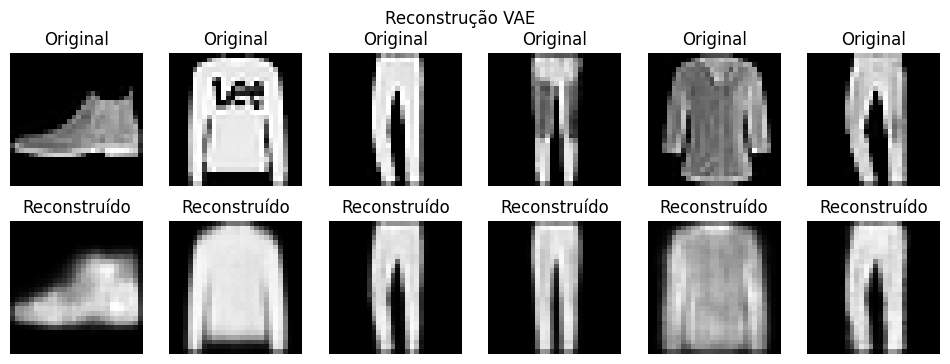

In [ ]:
def plot_reconstruction(model, dataset, n=5):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(DataLoader(dataset, batch_size=n)))
        x = x.to(device)
        recon, _, _ = model(x)
        x = x.cpu().numpy()
        recon = recon.cpu().numpy()

        plt.figure(figsize=(2 * n, 4))
        for i in range(n):
            # Original
            plt.subplot(2, n, i + 1)
            plt.imshow(x[i][0], cmap='gray')
            plt.title("Original")
            plt.axis('off')

            # Reconstruído
            plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon[i][0], cmap='gray')
            plt.title("Reconstruído")
            plt.axis('off')
        plt.suptitle("Reconstrução VAE")
        plt.show()

plot_reconstruction(model, test_dataset, n=6)